## Working with MB-System Grids in Python
### Monica Schwehr, <mschwehr@mbari.org>

#### Concepts covered:

1. Opening and reading a grid
2. Viewing metadata
3. Plotting data, overlaying contours
4. Creating a histogram of depths
5. Find locations matching a specific grid value (in this case depth)
6. Return the depth value for a given location

This notebook will also show how to use magics to run cells in another language besides python

This notebook uses a multibeam grid collected via AUV over the Endeavour Seamount by the Monterey Aquarium Research Institute in 2008. It is publically available via the MGDS data portal (http://www.marine-geo.org/tools/search/Files.php?data_set_uid=21403) Grid name: EndeavourAUVTopo2m.grd. 

These data are part of a larger data synthesis over Endeavour.

**Citation:** Kelley, D.; Delaney, J.; Yoerger, D.; Caress, D.; Clague, D. and A. Denny, (2015). Processed Bathymetry Grids (NetCDF:GMT format) derived from Multibeam Sonar Data from the Juan de Fuca - Endeavour Spreading Center Segment assembled as part of the JdF:Endeavour_Bathymetry Data Compilation. Integrated Earth Data Applications (IEDA). doi: http://dx.doi.org/10.1594/IEDA/321403.

In [1]:
%matplotlib inline

from osgeo import osr, gdal
import numpy as np
import matplotlib.pyplot as plt

### Reading the grid with gdal

We open the grid with gdal and can get some basic information such as how many bands (e.g., depth, reflectance value, etc.), the nodata value, projection, etc.

In [2]:
# Edit with your own path to the grid file,
Endeav = '/home/mschwehr/TestData/EndeavourAUVTopo2m.grd'

src = gdal.Open(Endeav)
band = src.GetRasterBand(1)
nodata_val = band.GetNoDataValue()
data_proj = src.GetProjectionRef()

print band
print nodata_val
print data_proj

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f1c2c37b2a0> >
nan



### Missing projection

So notice that the data_proj called returned a blank.

Let's looks at all the metadata:

In [3]:
src.GetMetadata()

{'NC_GLOBAL#Conventions': 'COARDS/CF-1.0',
 'NC_GLOBAL#GMT_version': '4.5.5 [64-bit]',
 'NC_GLOBAL#description': '\n\tProjection: Geographic\n\tGrid created by mbgrid\n\tMB-system Version 5.2.1884\n\tRun by <paje> on <menard.shore.mbari.org> at <Tue Mar 15 22:02:29 2011>',
 'NC_GLOBAL#title': 'Topography Grid',
 'x#actual_range': '{-129.1409,-129.0559}',
 'x#long_name': 'Longitude',
 'y#actual_range': '{47.8823,48.0052}',
 'y#long_name': 'Latitude',
 'z#_FillValue': '-nan',
 'z#actual_range': '{-2410.263916015625,-1948.4140625}',
 'z#long_name': 'Topography (m)'}


So we can see the projection is only written into the description, not into the projection flag. 

We can also see that the grid was created with MB-System, version 5.2.1184 by "paje" on Mar 15, 2011. The lat, long, and depth ranges are also given. 

-----

### Using Magics

Even though this is a python notebook, we can use magics in individual cells to run bash commands. 
Magics use two percent symbols (%%) followed by the name of the language you want to use.

So let's try the bash command gdalinfo on the grid and see if we can find anymore info.

-----

In [4]:
%%bash

gdalinfo '/home/mschwehr/TestData/EndeavourAUVTopo2m.grd'

Driver: netCDF/Network Common Data Format
Files: /home/mschwehr/TestData/EndeavourAUVTopo2m.grd
Size is 3176, 6833
Coordinate System is `'
Origin = (-129.140913385826764,48.005208994437943)
Pixel Size = (0.000026771653543,-0.000017988875878)
Metadata:
  NC_GLOBAL#Conventions=COARDS/CF-1.0
  NC_GLOBAL#description=
	Projection: Geographic
	Grid created by mbgrid
	MB-system Version 5.2.1884
	Run by <paje> on <menard.shore.mbari.org> at <Tue Mar 15 22:02:29 2011>
  NC_GLOBAL#GMT_version=4.5.5 [64-bit]
  NC_GLOBAL#title=Topography Grid
  x#actual_range={-129.1409,-129.0559}
  x#long_name=Longitude
  y#actual_range={47.8823,48.0052}
  y#long_name=Latitude
  z#actual_range={-2410.263916015625,-1948.4140625}
  z#long_name=Topography (m)
  z#_FillValue=-nan
Corner Coordinates:
Upper Left  (-129.1409134,  48.0052090) 
Lower Left  (-129.1409134,  47.8822910) 
Upper Right (-129.0558866,  48.0052090) 
Lower Right (-129.0558866,  47.8822910) 
Center      (-129.0984000,  47.9437500) 
Band 1 Block=317

-----

So we are getting essentially the same info, but this format is actually a bit easier to read.

Since MB-System uses GMT to make grids, let's also check the output of GMT grdinfo just to be complete

-----

In [5]:
%%bash

gmt grdinfo '/home/mschwehr/TestData/EndeavourAUVTopo2m.grd'


/home/mschwehr/TestData/EndeavourAUVTopo2m.grd: Title: Topography Grid
/home/mschwehr/TestData/EndeavourAUVTopo2m.grd: Command: 
/home/mschwehr/TestData/EndeavourAUVTopo2m.grd: Remark: 
	Projection: Geographic
	Grid created by mbgrid
	MB-system Version 5.2.1884
	Run by <paje> on <menard.shore.mbari.org> at <Tue Mar 15 22:02:29 2011>
/home/mschwehr/TestData/EndeavourAUVTopo2m.grd: Gridline node registration used [Geographic grid]
/home/mschwehr/TestData/EndeavourAUVTopo2m.grd: Grid file format: nf = GMT netCDF format (32-bit float), COARDS, CF-1.5
/home/mschwehr/TestData/EndeavourAUVTopo2m.grd: x_min: -129.1409 x_max: -129.0559 x_inc: 2.67716535433e-05 name: Longitude nx: 3176
/home/mschwehr/TestData/EndeavourAUVTopo2m.grd: y_min: 47.8823 y_max: 48.0052 y_inc: 1.79888758782e-05 name: Latitude ny: 6833
/home/mschwehr/TestData/EndeavourAUVTopo2m.grd: z_min: -2410.26391602 z_max: -1948.4140625 name: Topography (m)
/home/mschwehr/TestData/EndeavourAUVTopo2m.grd: scale_factor: 1 add_offset: 

#### Still no projection flag
So it looks like GMT stores projection in the Description field which GDAL cannot natively parse. 

This is not a big deal, so long as we know what the projection is, in case we want to do any transformations.

-----

We can see from gmt grdinfo that we have 3176 Longitudes and 6833 Latitudes, meaning our grid will 6833 x 3176

### Now back to the grid
Let's check our band count, and then read that band into an array called "depth"

grids can have multiple bands to store data (e.g., temp, salinity, depth, etc.)



In [6]:
band_c = src.RasterCount
print band_c


1


#### Read band data into a numpy aray

So we have one band, which we know is depth

We can read our depth values in to a numpy array and check that the shape matches what got from the metadata

In [7]:
depth = band.ReadAsArray()
print type(depth)
depth.shape

<type 'numpy.ndarray'>


(6833, 3176)

### Plotting data

We use matplotlib to plot the data, set the colormap, and add a colorbar

We can see from the metadata that the origin is upper left, so that is where (0,0) should be


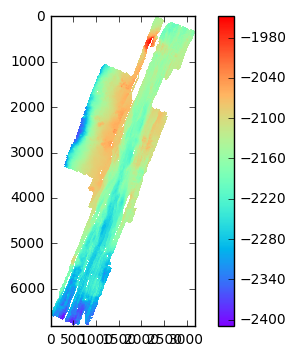

In [8]:
imgplot = plt.imshow(depth, interpolation='none')
imgplot.set_cmap('rainbow')
plt.colorbar()

Now let's change our axes to match our actual X,Y coordinates

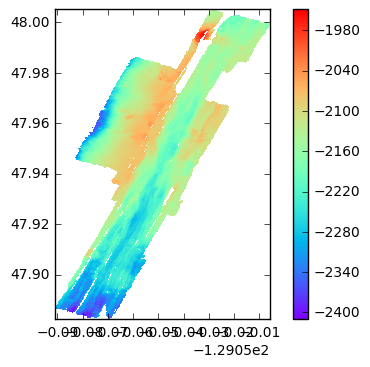

In [9]:
# got bounds from src.GetMetadata()

imgplot = plt.imshow(depth, interpolation='none')
imgplot.set_extent([-129.1409,-129.0559,47.8823,48.0052])
imgplot.set_cmap('rainbow')
plt.colorbar()


In [10]:
imgplot.get_extent()

[-129.1409, -129.0559, 47.8823, 48.0052]

We can the number of cols and rows in our grid:

In [11]:
imgplot.get_size()

(6833, 3176)

### Contouring our data

We can use countour from MatPlotLib to contour our data and overlay it on our grid.

**Note:** That if we contour *without* referencing our grid, the command does not read in the origin from the grid and automatically puts the origin in the lower left. 

To view just contours correctly, we need to invert the y-axis

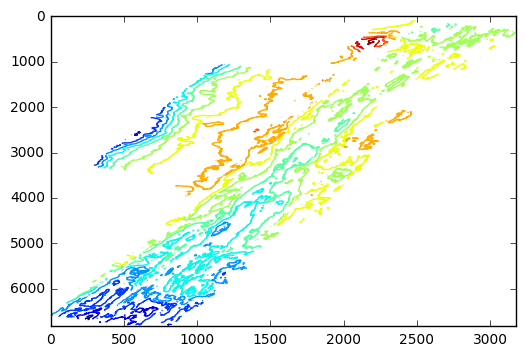

In [12]:
img_cont = plt.contour(depth,15)
img_cont.ax.invert_yaxis()

#### Now let's plot our grid and overlay the contours

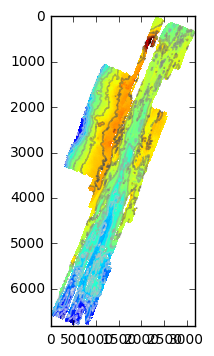

In [13]:
from matplotlib import cm

f = plt.figure()
ax = f.add_subplot(111)

ax.imshow(depth, interpolation='none')
ax.contour(depth,15,cmap=cm.Greys, alpha = 0.5)


#### Playing with contours
We can also specify the contour levels or the number of contours

In [14]:
#ax.contour(depth,levels=[-2400 -2300 -2200 -2100],cmap=cm.Greys)

#### To-Do:
    1. Fix format of X and Y axes for easier reading when using set extents
    2. Figure out why when you set extents for contours overlaid on bathy, there appears to be an offset
    3. Figure out how to change display size of --inline plots 

### Histograms

Histograms are easy to make, but we must manually filters the NaNs first. Hist will not do it for us.

#### There are 3 hist styles:
    1. align left: bars are centered on left bin edges
    2. align right: " right"
    3. align mid: bars centered between bin edges - DEFAULT
    

We can easily store the bins and counts that results from out hist function

Note that in this instance, the bins defines the bounds of our bars, so we will have one more bin than count

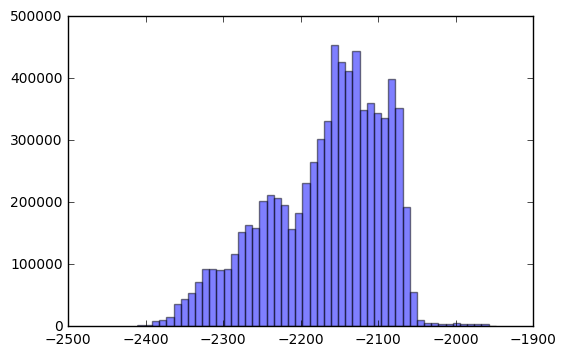

In [15]:
# Here we use the semi-colon to suppress data output. 
# If we remove it, Python will print the data that accompanies this plot (bins & counts)

n, bins, patches = plt.hist(depth[~np.isnan(depth)],50,alpha=0.5);

In [16]:
print n.size
print bins.size

50
51


### Get the Coordinate Informtion of the Grid

We can use the Gdal command GeoTransform to get all the info we need about the grid to locate it with the world, and to project or transform the data. 
  + 1st number [0]: Top Left (X)
  + 2nd number [1]: w-e pixel resolution (Long)
  + 3rd number [2]: rotation, (0 if image is north up)
  + 4th number [3]: Top Left (Y)
  + 5th number [4]: rotation, (0 if image is north up)
  + 6th number [5]: n-s pixel resolution (Lat)

In [17]:
gt = src.GetGeoTransform()
print gt

(-129.14091338582676, 2.6771653543300642e-05, 0.0, 48.00520899443794, 0.0, -1.7988875878220336e-05)


### Projection to/from XY and Cartesian coordinates

We can use the info from the geotransform to convert from our map units (in this case Lat,Long) to column and row number. This is important if we want to extract a depth from the grid at a specific location:


#### col, row -> Lat, Long using geotransform
Long = (col * gt[1]) + gt[0]

Lat = (row * gt[5]) + gt[3]

#### Lat, Long -> col, row using the inverse of the geotransform
##### Note that we need to round and then convert to integer to get the closest possible grid cell to our location

Col = int(round((Long - gt[0]) / gt[1]))

Row = int(round((Lat- gt[3]) / gt[5]))


In [18]:
# so let's pick a lat, long somewhere within our grid

lon,lat = [-129.1,47.96]

row = int(round((lat - gt[3]) / gt[5]))
col = int(round((lon - gt[0])/gt[1]))

print row, col

depth_point = depth[row,col]
print '%.15g' % depth_point

2513 1528
-2084.39501953125


We can check our results by finding the cells that match a specific depth value using numpy

In [19]:
(row_index, col_index) = np.where(depth == depth_point)

print row_index.size, col_index.size

# so we see that there are 19 grid points with same depth as our extracted point. 

for index, y in enumerate(row_index):
    if y == row:
        print 'yes ',index
        
for index, x in enumerate(col_index):
      if x == col:
        print 'yes', index
        

19 19
yes  7
yes 7


Alright. So what we did above what to create an index of col and row locations where the depth of the cell matches the depth of our extracted point.

Since there are multiple locations, we looped through each index and made sure the col and row values of our selected point were contained within the index, at the same location (index num)